In [1]:
import random
import time
import os

import cv2
import numpy as np

import torch
import torchvision
from PIL import Image, ImageFilter
from IPython import display

import torchvision.models
from torchvision.transforms import transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import imagehash

In [72]:
base = "Train/Game"
classes = ["Full Body Sitting", "Full Body Standing", "Half Body", "Head Only"]

input_directories = [f"./temporal_data_extraction/human_poses_classified/{base}/{class_name}" for class_name in classes]

In [39]:
max_segments_from_image = -1
width_height_counts = {}
area_counts = {}

for input_directory in input_directories:
    print(input_directory)
    for image_name in tqdm(os.listdir(input_directory)):
        if image_name.split(".")[-1] != "jpg":
            continue
            
        segment_count = int(image_name.split("_")[-1].split(".")[0])
        
        if segment_count > max_segments_from_image:
            max_segments_from_image = segment_count
        
        image_location = f"{input_directory}/{image_name}"
        image = Image.open(image_location)
        width, height = image.size
        
        size_tup = (width, height)
        area = width * height
        
        if size_tup not in width_height_counts.keys():
            width_height_counts[size_tup] = 0
            
        if area not in area_counts.keys():
            area_counts[area] = 0
        
        width_height_counts[size_tup] += 1
        area_counts[area] += 1

./temporal_data_extraction/human_poses_classified/Train/Movie/Full Body Sitting


  0%|          | 0/55 [00:00<?, ?it/s]

./temporal_data_extraction/human_poses_classified/Train/Movie/Full Body Standing


  0%|          | 0/1157 [00:00<?, ?it/s]

./temporal_data_extraction/human_poses_classified/Train/Movie/Half Body


  0%|          | 0/5331 [00:00<?, ?it/s]

./temporal_data_extraction/human_poses_classified/Train/Movie/Head Only


  0%|          | 0/3661 [00:00<?, ?it/s]

(array([ 513.,  748.,  759.,  678.,  449.,  602., 1043.,  548.,  883.,
         465.,  576.,  490.,  334.,  301.,  296.,  401.,  261.,  522.,
         299.,   36.]),
 array([   510. ,   8437.7,  16365.4,  24293.1,  32220.8,  40148.5,
         48076.2,  56003.9,  63931.6,  71859.3,  79787. ,  87714.7,
         95642.4, 103570.1, 111497.8, 119425.5, 127353.2, 135280.9,
        143208.6, 151136.3, 159064. ]),
 <BarContainer object of 20 artists>)

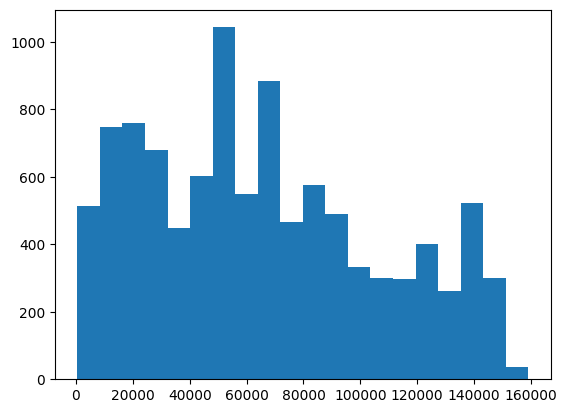

In [40]:
# https://stackoverflow.com/a/66737321
mylist = [key for key, val in area_counts.items() for _ in range(val)]
plt.hist(mylist, bins=20)

In [41]:
max_segments_from_image

8

In [42]:
cutoff = 8
window = 5

In [43]:
def group_similar_images(ordered_dir, cutoff, window):
    image_locs = [f"{ordered_dir}/{file_name}" for file_name in os.listdir(ordered_dir) if file_name.endswith(".jpg")]
    groups = [[image_locs[0]]]
    
    for image_loc in tqdm(image_locs):
        img_hash = imagehash.average_hash(Image.open(image_loc))
        
        closest_group_idx = -1
        closest_group_diff = 65
        
        for offset, group in enumerate(groups[-window:][::-1]):
            group_idx = len(groups) - offset - 1
            last_hash = imagehash.average_hash(Image.open(group[-1]))
            diff = img_hash - last_hash
            
            if diff < closest_group_diff:
                closest_group_idx = group_idx
                closest_group_diff = diff
        
        diff = img_hash - last_hash
        
        if closest_group_diff <= cutoff:
            groups[closest_group_idx].append(image_loc)
        else:
            groups.append([image_loc])
    
    return groups

In [44]:
groups = []

for input_directory in input_directories:
    dir_groups = group_similar_images(input_directory, cutoff, window)
    print(len(dir_groups))
    groups += dir_groups

  0%|          | 0/55 [00:00<?, ?it/s]

45


  0%|          | 0/1157 [00:00<?, ?it/s]

251


  0%|          | 0/5331 [00:00<?, ?it/s]

425


  0%|          | 0/3661 [00:00<?, ?it/s]

607


In [55]:
target_test_count = 250
min_triplets_from_clip = 3
max_triplets_from_clip = 5
output_size = 256
min_size = 96

In [61]:
train_output_directory = f"./temporal_data_extraction/triplets/{base}/Train"
test_output_directory = f"./temporal_data_extraction/triplets/{base}/Test"

os.makedirs(train_output_directory, exist_ok=False)
os.makedirs(test_output_directory, exist_ok=False)

In [62]:
lengths = {}
min_length = min_triplets_from_clip * 3
excluded_count = 0

for group in groups:
    l = len(group)
    
    if l < min_length:
        excluded_count += l
        continue
    
    if l not in lengths.keys():
        lengths[l] = 0
    
    lengths[l] += 1

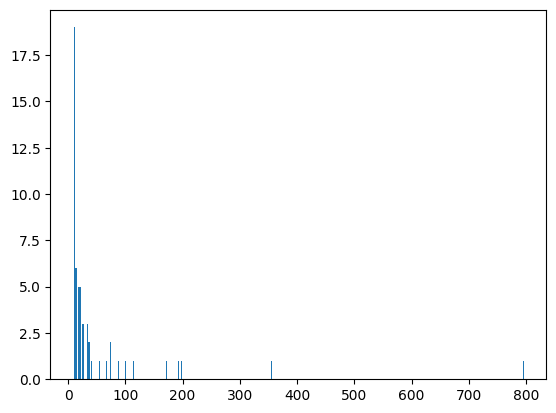

In [63]:
plt.bar(*zip(*lengths.items()))
plt.show()

In [64]:
excluded_count

2537

In [65]:
test_save_prob = target_test_count / excluded_count

for group_no, group in enumerate(tqdm(groups)):
    if len(group) < min_length:
        for i in range(len(group)):
            if random.uniform(0, 1) < test_save_prob:
                Image.open(group[i]).save(f"{test_output_directory}/{group_no:05d}_{i:05d}.jpg")
        
        continue
        
    triplet_count = len(group) // 3
    selection_count = min(triplet_count, max_triplets_from_clip)
    selected_triplets = random.sample(range(triplet_count), k=selection_count)
    
    for i in selected_triplets:
        triplet_image = Image.new("RGB", (3 * output_size, output_size))
        
        x = Image.open(group[3 * i])
        y = Image.open(group[3 * i + 1])
        z = Image.open(group[3 * i + 2])
        
        if x.width < min_size or x.height < min_size:
            continue
            
        if y.width < min_size or y.height < min_size:
            continue
            
        if z.width < min_size or z.height < min_size:
            continue
        
        triplet_image.paste(x.resize((output_size, output_size)), (0, 0))
        triplet_image.paste(y.resize((output_size, output_size)), (output_size, 0))
        triplet_image.paste(z.resize((output_size, output_size)), (2 * output_size, 0))
        
        triplet_image.save(f"{train_output_directory}/{group_no:05d}_{i:05d}.jpg")

  0%|          | 0/1328 [00:00<?, ?it/s]

In [73]:
target_size = 600
input_train_output_directory = f"./temporal_data_extraction/triplets/{base}/Train"

In [74]:
valid_input_files = [file_name for file_name in os.listdir(input_train_output_directory) if file_name.endswith(".jpg")]

In [75]:
if len(valid_input_files) > target_size:
    selected_for_delete = random.sample(valid_input_files, k=len(valid_input_files) - target_size)
    
    for file_name in selected_for_delete:
        os.remove(f"{input_train_output_directory}/{file_name}")
    
    print("Deleted", len(selected_for_delete), "files")

Deleted 242 files
